# k‑Nearest Neighbours (k‑NN) — From Scratch (Fully Commented)

A minimal **NumPy‑only** implementation of the classic **k‑Nearest Neighbours**
algorithm for binary classification.  We will:

1. Build a 2‑D toy dataset  
2. Implement distance computation and voting from first principles  
3. Explore how the choice of **k** affects the decision boundary  
4. Evaluate accuracy and visualise the results  

*(Generated 2025-06-05)*


## 1. Quick Theory Recap

Given a query point **x**, *k*‑NN:

* Finds the **k** closest points in the training set (usually Euclidean distance).  
* Lets them **vote** — most common label wins (for classification; mean for regression).  

No training phase!  All the work happens at query time.

The classifier is **non‑parametric** (model complexity grows with data) and the
decision boundary can be highly non‑linear.


### 2. Imports & synthetic data

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Set random seed for reproducibility
np.random.seed(0)

# 2. Parameters
N_PER_CLASS = 100
FEATURES = 5

# 3. Define distinct means for each class
mean0 = np.array([-3, -5, 0, 5, 3])    # Class 0
mean1 = np.array([4, 1, 4.5, 0.67, 2.44])   # Class 1

# 4. Generate data from standard normal, then shift by class mean
X0 = np.random.randn(N_PER_CLASS, FEATURES) + mean0
X1 = np.random.randn(N_PER_CLASS, FEATURES) + mean1

# 5. Combine data and labels
X_train = np.vstack([X0, X1])  # shape: (200, 5)
y_train = np.hstack([np.zeros(N_PER_CLASS), np.ones(N_PER_CLASS)])  # shape: (200,)
y_train = y_train.reshape(-1, 1)  # shape: (200, 1)

# 6. Print shape info
print(f'Train set: X {X_train.shape}, y {y_train.shape}')

Train set: X (200, 5), y (200, 1)


### 3. Helper functions

In [9]:
def euclidean_distances(X, x_query):
    """
    Compute L2 (Euclidean) distances from each row in X to a single query point x_query.
    
    Args:
        X (np.ndarray): Training data, shape (N, D)
        x_query (np.ndarray): Single query point, shape (D,)
    
    Returns:
        np.ndarray: Vector of distances, shape (N,)
    """
    # Subtract query point from each sample (broadcasting)
    diff = X - x_query  # shape: (N, D)
    
    # Square differences, sum over features, then square root
    return np.sqrt(np.sum(diff ** 2, axis=1))  # shape: (N,)


def knn_predict(x_query, X, y, k):
    """
    Predict the class of a single query point using K-Nearest Neighbours.
    
    Args:
        x_query (np.ndarray): Single query point, shape (D,)
        X (np.ndarray): Training data, shape (N, D)
        y (np.ndarray): Training labels, shape (N, 1) or (N,)
        k (int): Number of neighbours to consider
    
    Returns:
        int: Predicted class label
    """
    # 1. Compute distances to all training points
    dists = euclidean_distances(X, x_query)
    
    # 2. Find indices of the k nearest neighbours
    nearest_idx = np.argsort(dists)[:k]
    
    # 3. Extract their labels
    nearest_labels = y[nearest_idx].ravel()
    
    # 4. Count frequency of each label
    counts = np.bincount(nearest_labels.astype(int))
    
    # 5. Return label with highest count
    return np.argmax(counts)


def knn_batch(X_query, X, y, k):
    """
    Predict the classes for multiple query points.
    
    Args:
        X_query (np.ndarray): Query set, shape (M, D)
        X (np.ndarray): Training data, shape (N, D)
        y (np.ndarray): Training labels, shape (N, 1)
        k (int): Number of neighbours to consider
    
    Returns:
        np.ndarray: Predicted labels for X_query, shape (M, 1)
    """
    # Predict each query point one by one
    preds = [knn_predict(x, X, y, k) for x in X_query]
    
    # Convert list to column vector
    return np.array(preds).reshape(-1, 1)


def accuracy(y_true, y_pred):
    """
    Calculate accuracy of predictions.
    
    Args:
        y_true (np.ndarray): Ground truth labels, shape (N, 1) or (N,)
        y_pred (np.ndarray): Predicted labels, shape (N, 1) or (N,)
    
    Returns:
        float: Accuracy score (0 to 1)
    """
    return np.mean(y_true == y_pred)


### 4. Baseline accuracy for several k values

In [10]:
for k in [1, 3, 5, 15]:
    y_pred = knn_batch(X_train, X_train, y_train, k)  # Predict labels for training data
    print(f'k = {k:2d}  |  training accuracy = {accuracy(y_train, y_pred):.3f}')

k =  1  |  training accuracy = 1.000
k =  3  |  training accuracy = 1.000
k =  5  |  training accuracy = 1.000
k = 15  |  training accuracy = 1.000


### 5. Visualising decision boundaries

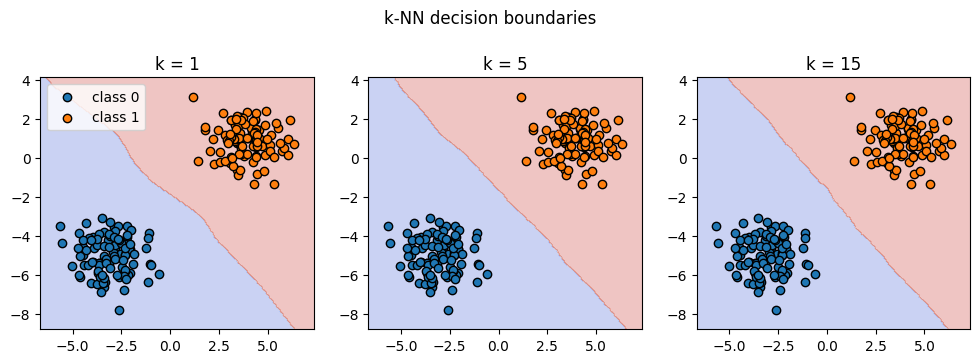

In [11]:
def plot_decision_boundary(k, ax):
    """
    Plot decision boundary for KNN with a given 'k' on the first two features.

    Args:
        k (int): Number of neighbours
        ax (matplotlib axis): Axis to plot on
    """
    # Define plotting range for first two features
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1

    # Create a mesh grid (graph paper)
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))

    # Create 2D input grid
    grid = np.c_[xx.ravel(), yy.ravel()]

    # 🔧 FIXED: use only first 2 features of training data
    preds = knn_batch(grid, X_train[:, :2], y_train, k)
    Z = preds.reshape(xx.shape)

    # Draw decision boundaries
    ax.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')

    # Plot class 0 and class 1 (first two features only)
    ax.scatter(X0[:, 0], X0[:, 1], label='class 0', edgecolor='k')
    ax.scatter(X1[:, 0], X1[:, 1], label='class 1', edgecolor='k')

    ax.set_title(f'k = {k}')
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_aspect('equal')


# Create subplots for 3 k values
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for ax, k in zip(axes, [1, 5, 15]):
    plot_decision_boundary(k, ax)

axes[0].legend()
plt.suptitle('k-NN decision boundaries')
plt.show()


### 6. Quick cross‑validation for optimal k

Below we perform a trivial **leave‑one‑out** CV to choose k that maximises
validation accuracy.  (Costly for large data but fine here.)


In [12]:
def loo_cv_score(k):
    """
    Perform Leave-One-Out Cross-Validation (LOO-CV) to estimate
    KNN performance for a specific k.

    Args:
        k (int): Number of neighbours

    Returns:
        float: Cross-validation accuracy score
    """
    correct = 0                      # Count of correct predictions
    N = len(X_train)                 # Total number of training samples

    for i in range(N):
        # Remove the i-th point from training data
        X_loo = np.delete(X_train, i, axis=0)   # shape: (N-1, D)
        y_loo = np.delete(y_train, i, axis=0)   # shape: (N-1, 1)

        # Predict label for the left-out point
        pred = knn_predict(X_train[i], X_loo, y_loo, k)

        # Compare prediction with true label
        if pred == y_train[i, 0]:
            correct += 1  # Count as correct prediction

    return correct / N  # Accuracy = correct predictions / total samples


k_values = range(1, 16, 2)
scores = [loo_cv_score(k) for k in k_values]

best_k = k_values[int(np.argmax(scores))]
print("k values:", list(k_values))
print("LOO‑CV scores:", [round(s,3) for s in scores])
print(f"Best k (highest CV accuracy) = {best_k}")

# Define the list of k values to evaluate
k_values = range(1, 16, 2)  # [1, 3, 5, ..., 15]

# Compute LOO-CV score for each k
scores = [loo_cv_score(k) for k in k_values]

# Find the k with the highest score
best_k = k_values[int(np.argmax(scores))]

# Print results
print("k values:", list(k_values))
print("LOO‑CV scores:", [round(s, 3) for s in scores])
print(f"Best k (highest CV accuracy) = {best_k}")


k values: [1, 3, 5, 7, 9, 11, 13, 15]
LOO‑CV scores: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Best k (highest CV accuracy) = 1
k values: [1, 3, 5, 7, 9, 11, 13, 15]
LOO‑CV scores: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Best k (highest CV accuracy) = 1


### 7. Next steps

* **KD‑Tree / Ball‑Tree** – accelerate nearest‑neighbour search for higher‑dim data.  
* **Distance metrics** – try Manhattan, cosine, Minkowski, learned metrics…  
* **Weighted voting** – weight neighbours by inverse distance.  
* **Regression variant** – output mean of neighbour targets instead of majority vote.  
* **Dimensionality reduction** – PCA or t‑SNE to mitigate the *curse of dimensionality*.
